In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

## Load the data into a DataFrame
djs = pd.read_csv('assets/Iowa_Liquor_sales_sample_10pct.csv', encoding='latin-1')
df = pd.read_csv('assets/iowa_15.csv', encoding='latin-1')

pd.options.mode.chained_assignment = None

In [2]:
#Add more date info
djs['Date Formatted']=[datetime.strptime(x, '%m/%d/%Y').date() for x in djs['Date']]

In [3]:
#DOUG'S CODE OF CONDUCT

#Converts State Bottle Cost Series to Float
djs['State Bottle Cost'] = (djs['State Bottle Cost'].replace( '[\$,)]','', regex=True )\
                            .replace( '[(]','-',   regex=True ).astype(float))

#Converts State Bottle Retail Series to Float
djs['State Bottle Retail'] = (djs['State Bottle Retail'].replace( '[\$,)]','', regex=True )\
                              .replace( '[(]','-',   regex=True ).astype(float))

#Converts Sale Dollars Series to Float
djs['Sale (Dollars)'] = (djs['Sale (Dollars)'].replace( '[\$,)]','', regex=True )\
                         .replace( '[(]','-',   regex=True ).astype(float))

djs['City'] = map(lambda x: x.upper(), djs['City'])


djs['Profit'] = djs['Sale (Dollars)'] - (djs['State Bottle Cost'] * djs['Bottles Sold'])

#Does date stuff
djs['Date'] = pd.to_datetime(djs["Date"])
djs['Year'], djs['Month'] = djs['Date'].dt.year, djs['Date'].dt.month

In [4]:
#Reading in City/County name and estimated 2015 population
name_df = df.iloc[:,8:9]
pop_df = df.iloc[:,17:]

name_pop_df = pd.concat([name_df, pop_df], axis=1)
name_pop_df['NAME'] = (name_pop_df['NAME'].replace( ' city','', regex=True ))

temp_df = name_pop_df.T
temp_df = temp_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "(pt.)" not in x]].T
name_pop_df = temp_df.reset_index(drop=True)

temp_df = name_pop_df.T
temp_df = temp_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "Balance" not in x]].T
name_pop_df = temp_df.reset_index(drop=True)

name_pop_df = name_pop_df.sort(columns=['NAME'])

#name_pop_df['NAME'] = (name_pop_df['NAME'].replace( "ARNOLDS PARK","ARNOLD'S PARK", regex=True))

name_pop_df = name_pop_df.drop_duplicates(keep='first').reset_index(drop=True)

/Users/Jesse/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [5]:
#Add County Population
temp_df = name_pop_df.T
temp_df = temp_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "County" in x]]
temp_df = temp_df.T

temp_df['NAME'] = (temp_df['NAME'].replace( ' County','', regex=True ))
temp_df = temp_df.reset_index(drop=True)

djs = djs.merge(temp_df, how='left', left_on='County', right_on='NAME')
del djs['NAME']
djs.rename(columns={'POPESTIMATE2015':'County Pop'}, inplace = True)



#Add City Population
temp_df = name_pop_df.T
temp_df = temp_df[[ind for ind, x in enumerate(name_pop_df['NAME']) if "County" not in x]]
temp_df = temp_df.T

temp_df = temp_df.reset_index(drop=True)
temp_df['NAME'] = map(lambda x: x.upper(), temp_df['NAME'])

djs = djs.merge(temp_df, how='left', left_on='City', right_on='NAME')
tested = temp_df
del djs['NAME']
djs.rename(columns={'POPESTIMATE2015':'City Pop'}, inplace = True)

In [6]:
djs.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Date Formatted,Profit,Year,Month,County Pop,City Pop
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,12,81.00,9.0,2.38,2015-11-04,27.00,2015,11,24722,2009
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,...,2,41.26,1.5,0.40,2016-03-02,13.76,2016,3,172126,102582
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,...,24,453.36,24.0,6.34,2016-02-11,151.20,2016,2,133455,41255
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,...,6,85.50,10.5,2.77,2016-02-03,28.50,2016,2,96021,65060
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,12,129.60,21.0,5.55,2015-08-18,43.20,2015,8,12773,2314


In [7]:
test = djs.iloc[:, 1:3]

test = test.drop_duplicates(keep='first')
test = test.groupby('City').count()
test.rename(columns={'Store Number':'Store Count by City'}, inplace = True)

djs = djs.merge(test, how='left', left_on='City', right_index=True)

djs_profit_by_city = djs.groupby(['City'])['Profit'].agg(([np.sum]))
djs_profit_by_county = djs.groupby(['County'])['Profit'].agg(([np.sum]))

djs_profit_by_city.rename(columns={'sum':'Profit by City'}, inplace = True)
djs_profit_by_county.rename(columns={'sum':'Profit by County'}, inplace = True)

djs = djs.merge(djs_profit_by_city, how='left', left_on='City', right_index=True)
djs = djs.merge(djs_profit_by_county, how='left', left_on='County', right_index=True)

In [8]:
djs.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,Volume Sold (Gallons),Date Formatted,Profit,Year,Month,County Pop,City Pop,Store Count by City,Profit by City,Profit by County
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,2.38,2015-11-04,27.00,2015,11,24722,2009,1,3848.59,68557.11
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,...,0.40,2016-03-02,13.76,2016,3,172126,102582,44,573073.66,824275.97
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,...,6.34,2016-02-11,151.20,2016,2,133455,41255,17,216846.33,647119.93
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,...,2.77,2016-02-03,28.50,2016,2,96021,65060,25,328097.33,359465.17
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,5.55,2015-08-18,43.20,2015,8,12773,2314,3,11449.65,26988.14


In [9]:
city_test = djs['City']
city_pop_test = djs['City Pop']
testee = pd.concat([city_test, city_pop_test], axis=1)
testee = testee.set_index(testee['City'])
del testee['City']
testee.sort().head()

/Users/Jesse/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(....) is deprecated, use sort_index(.....)


,City Pop
City,
ACKLEY,1560
ACKLEY,1560
ACKLEY,1560
ACKLEY,1560
ACKLEY,1560


In [10]:
testee = test.merge(testee, how='left', left_index=True, right_index=True)

In [11]:
testee = testee.drop_duplicates(keep='first')
testee.dropna(inplace=True)
testee.head()

,Store Count by City,City Pop
City,,
ACKLEY,2,1560
ADAIR,2,728
ADEL,3,4245
AFTON,1,829
AKRON,1,1450


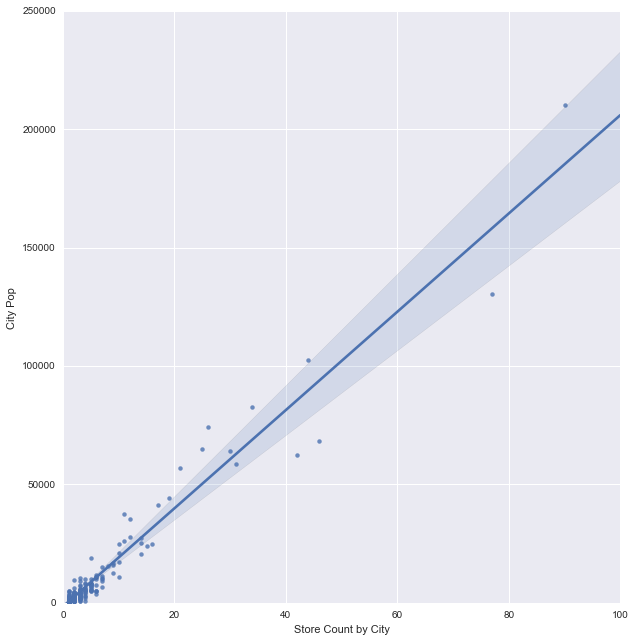

In [12]:
ax = sns.lmplot('Store Count by City', 'City Pop', data=testee, fit_reg=True, size=9)

ax.set(ylim=(0, None))
ax.set(xlim=(0, None))

In [13]:
targets = djs['Sale (Dollars)']
djstargets = pd.DataFrame(targets)
djstargets
lm = linear_model.LinearRegression()
X = djs[["State Bottle Retail", "Bottles Sold"]]
y = djstargets["Sale (Dollars)"]

model = lm.fit(X,y)
predictions = lm.predict(X)

MSE: 41542.7703728


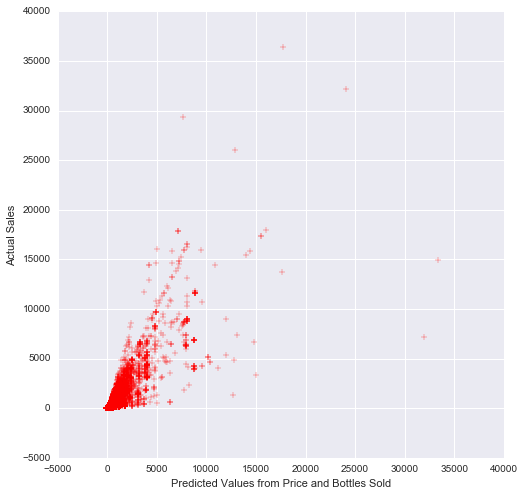

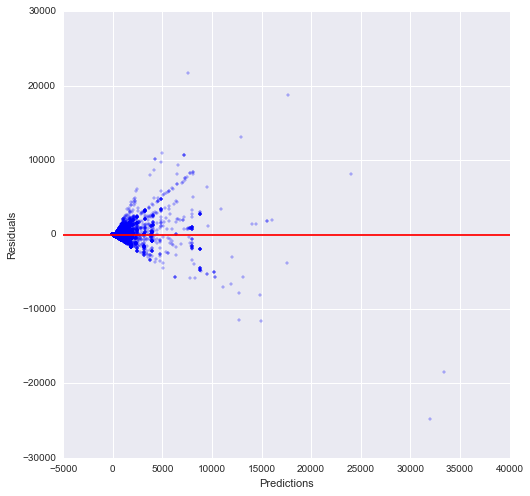

In [14]:
print "MSE:", mean_squared_error(y, predictions)
plt.figure(figsize=(8,8))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Price and Bottles Sold")
plt.ylabel("Actual Sales")
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(predictions, y - predictions, c = 'b', marker = '+')
plt.axhline(0, color='r');
plt.xlabel("Predictions")
plt.ylabel("Residuals");

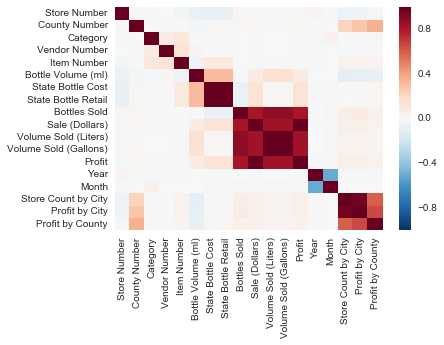

In [15]:
sns.heatmap(djs.corr());

In [16]:
key=djs[['Store Number', 'County','County Number', 'Zip Code', 'City']]
key.drop_duplicates(inplace=True)

key.set_index('Store Number', inplace=True)


key=key[pd.notnull(key['County Number'])]


KeyHelp=key.T


for i in range(len(djs['County Number'])):
   if np.isnan(djs['County Number'][i]):
       try:
           djs['County Number'][i]= KeyHelp[djs['Store Number'][i]][1]
       except: 
           djs['County Number'][i]


for i in range(len(djs['County'])):
   try:
       if np.isnan(djs['County'][i]):
           djs['County'][i]= KeyHelp[djs['Store Number'][i]][0]
   except: 
       djs['County'][i]


key.set_index('Zip Code', inplace=True)


KeyHelp=key.T


for i in range(len(djs['County Number'])):
   if np.isnan(djs['County Number'][i]):
       try:
           djs['County Number'][i]= KeyHelp[djs['Zip Code'][i]][1]
       except: 
           djs['County Number'][i]


for i in range(len(djs['County'])):
   try:
       if np.isnan(djs['County'][i]):
           djs['County'][i]= KeyHelp[djs['Zip Code'][i]][0]
   except: 
       djs['County'][i]

 
key.set_index('City', inplace=True)
KeyHelp=key.T

for i in range(len(djs['County Number'])):
   if np.isnan(djs['County Number'][i]):
       try:
           djs['County Number'][i]= KeyHelp[djs['City'][i]][1]
       except: 
           djs['County Number'][i]

for i in range(len(djs['County'])):
   try:
       if np.isnan(djs['County'][i]):
           djs['County'][i]= KeyHelp[djs['City'][i]][0]
   except: 
       djs['County'][i]

In [18]:
scatter_matrix(djs[['Date Formatted', 'Zip Code','Sale (Dollars)', 'State Bottle Retail','State Bottle Cost', 'Bottles Sold']], alpha=0.2, figsize=(12, 12), diagonal='Sale (Dollars)')


plt.plot_date(djs['Date Formatted'], djs['Sale (Dollars)'])
plt.show()

 
djs.dropna(inplace=True)


ValueError: ordinal must be >= 1